# Milestone 2 - CasierVert952

## Idea of project

# 🔴 TODO : Small text expliquant vite fait le projet 🔴


## Data

This data analysis will be conduct on multiple available datasets. 

- Data about beers come from two different beers rating websites :

    - BeerAdvocate
    - RateBeer

- External data about politics coming from ALBERTO websites :

    - blabla (link1)
    - blabla (link2)

> *In the following: BeerAdvocate will be abbreviated as BA and RateBeer as RB.*

> *For improved readability, the complex and long functions developed for this analysis have been moved to ```helpers.py```. We import these functions into the relevant cells as needed.*

## 0. Initial configuration

### 0.1 Data preprocessing

In this phase, we will start by demonstrating how we transformed the ```TXT``` ratings files (for both BA and RB) into CSV format. Next, we will merge the various data files and rename the columns to create a dataframes containing all available feature for each of the datasets. Afterward we will clean and modify some features such as dates and locations to meet our needs. Finally, we will save the cleaned data into ```CSV``` files to be able to load them quickly.

This step can be found on [data_preprocessing.ipynb](data_preprocessing.ipynb), which has to be entirely executed once to be able to run the following cells.

The ```data``` directory should now look like this :

```
data/
├── BeerAdvocate
│   ├── beers.csv
│   ├── breweries.csv
│   ├── users.csv
│   ├── ratings.csv
│   └── BA_cleaned.csv
│
└── RateBeer
    ├── beers.csv
    ├── breweries.csv
    ├── users.csv
    ├── ratings.csv
    └── RB_cleaned.csv
```

### 0.2 Importation of libraries and golbal variable declarations

In [101]:
# import the basic requiered libraries
import os
import csv
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# path variables
BA_DATA_PATH = "data/BeerAdvocate/"
RB_DATA_PATH = "data/RateBeer/"

import importlib
import helpers
importlib.reload(helpers)


<module 'helpers' from '/Users/jackdouniels/Downloads/GitHub/ada-2024-project-casiervert952/helpers.py'>

## 1. Data loading and visualization

### 1.1 Loading cleaned data

The preprocessing task having already been done, the cleaned data just has to be loaded.

In [43]:
# create Dataframes for the BA cleaned data
s_time = time.time()
BA_cleaned = pd.read_csv(BA_DATA_PATH + 'BA_cleaned.csv', low_memory=False)
e_time = time.time()
print("Loading of BA data ended in " + str(e_time - s_time) + " seconds.")

# create Dataframes for the RB cleaned data
s_time = time.time()
RB_cleaned = pd.read_csv(RB_DATA_PATH + 'RB_cleaned.csv', low_memory=False)
e_time = time.time()
print("Loading of RB data ended in " + str(e_time - s_time) + " seconds.")

# loading extra data useful for "Data exploration"
BA_beers = pd.read_csv(BA_DATA_PATH + 'beers.csv')
BA_breweries = pd.read_csv(BA_DATA_PATH + 'breweries.csv')
BA_users = pd.read_csv(BA_DATA_PATH + 'users.csv')
RB_beers = pd.read_csv(RB_DATA_PATH + 'beers.csv')
RB_breweries = pd.read_csv(RB_DATA_PATH + 'breweries.csv')
RB_users = pd.read_csv(RB_DATA_PATH + 'users.csv')

Loading of BA data ended in 385.3080198764801 seconds.
Loading of RB data ended in 67.30036497116089 seconds.


### 1.2 Data visualization

The following illustrates the structure of our data after preprocessing. In the future analysis, we will create derived DataFrames from ```BA_cleaned``` and ```RB_cleaned``` by copying them and then, removing, modifying, and adding features to these copies as needed.

In [44]:
# display 3 samples of the BA dataset
print("Visualization of BA :")
display(BA_cleaned.sample(3).T)

# display 3 samples of the RB dataset
print("\nVisualization of RB :")
display(RB_cleaned.sample(3).T)

Visualization of BA :


,7746662,560239,5477385
rating_date,12-2014,01-2014,10-2015
rating_appearance,NaN,3.75,3.5
rating_aroma,NaN,4.25,3.5
rating_palate,NaN,4.25,3.5
rating_taste,NaN,4.25,3.5
rating_overall,NaN,4.0,3.5
rating,4.25,4.17,3.5
beer_id,89689,87000,159838
beer_name,Moby (The Great White Ale),Santa's Little Helper 2012,Coco Noir
beer_style,Witbier,Belgian Strong Dark Ale,Dunkelweizen



Visualization of RB :


,5334600,5869934,6721050
rating_date,06-2014,07-2017,05-2011
rating_appearance,3,3,4
rating_aroma,6,5,5
rating_palate,2,3,1
rating_taste,4,6,5
rating_overall,10,11,11
rating,2.5,2.8,2.6
beer_id,29759,530399,6102
beer_name,Olde Burnside Father Christmas Highland Ale,Bohem Druid,St. Louis Kriek
beer_style,Scotch Ale,Schwarzbier,Lambic Style - Fruit


> *Here, it can be seen that there is the user's information and his rating on a particular beer. Attached to that, there is a variety of data about the beer characteristics and a varity of information about its corresponding brewery. It can also be seen that, sometimes, the fields are empty (NaN).*

## 2. Data exploration of the two beers' datasets 

Indeed, we are given two different but very similar datasets to perform our analysis. Let's begin by examining them to determine the best approach: using one dataset, combining both, or creating a blend of the two.


### 2.1 Sizes

We will first look into their size.

In [45]:
# print sizes of each Dataframe for both datasets.

print("BA :")
print("   Number of ratings   : " + str(BA_cleaned.shape[0]))
print("   Number of beers     : " + str(BA_beers.shape[0]))
print("   Number of breweries : " + str(BA_breweries.shape[0]))
print("   Number of users     : " + str(BA_users.shape[0]))

print("\nRB :")
print("   Number of ratings   : " + str(RB_cleaned.shape[0]))
print("   Number of beers     : " + str(RB_beers.shape[0]))
print("   Number of breweries : " + str(RB_breweries.shape[0]))
print("   Number of users     : " + str(RB_users.shape[0]))

BA :
   Number of ratings   : 8392192
   Number of beers     : 280823
   Number of breweries : 16758
   Number of users     : 153704

RB :
   Number of ratings   : 7123070
   Number of beers     : 442081
   Number of breweries : 24189
   Number of users     : 70174


> *The RB dataset contains more data on different beers and breweries, but less users than the BA one. Both datasets have around 7 millions user's ratings, which seems at first sight enough to perfom our analysis.*

### 2.2 Missing values

We will check how many value are missing the features columns. It will help us to decide what to remove during the "Data refinement" phase.

In [46]:
# compute missing values by columns
missing_count_BA = BA_cleaned.isna().sum()
missing_percentage_BA = (missing_count_BA / len(BA_cleaned)) * 100
missing_count_RB = RB_cleaned.isna().sum()
missing_percentage_RB = (missing_count_RB / len(RB_cleaned)) * 100

# put results in a dataframe
missing_data_BA = pd.DataFrame({
    'Column': BA_cleaned.columns,
    'Missing Values (BA)': missing_count_BA,
    '% (BA)': missing_percentage_BA
})
missing_data_RB = pd.DataFrame({
    'Column': RB_cleaned.columns,
    'Missing Values (RB)': missing_count_RB,
    '% (RB)': missing_percentage_RB
})

# sort by "%"
missing_data_BA = missing_data_BA.sort_values(by='% (BA)', ascending=False)
missing_data_RB = missing_data_RB.sort_values(by='% (RB)', ascending=False)

# print results
display(missing_data_BA, missing_data_RB)

,Column,Missing Values (BA),% (BA)
beer_avg_matched_valid_ratings,beer_avg_matched_valid_ratings,7464671,88.947810
beer_zscore,beer_zscore,7436327,88.610068
beer_bros_score,beer_bros_score,5283785,62.960726
rating_aroma,rating_aroma,3622979,43.170831
rating_palate,rating_palate,3622979,43.170831
rating_taste,rating_taste,3622979,43.170831
rating_overall,rating_overall,3622979,43.170831
rating_appearance,rating_appearance,3622979,43.170831
breweries_state,breweries_state,1481852,17.657508
user_state,user_state,1089052,12.976967


,Column,Missing Values (RB),% (RB)
beer_zscore,beer_zscore,6102391,85.670799
beer_avg_matched_valid_ratings,beer_avg_matched_valid_ratings,6102391,85.670799
breweries_state,breweries_state,4111124,57.715620
user_state,user_state,4014385,56.357512
overall_score,overall_score,861022,12.087794
style_score,style_score,844833,11.860518
user_country,user_country,203670,2.859301
user_location,user_location,203670,2.859301
beer_abv,beer_abv,174964,2.456300
user_join_date,user_join_date,2625,0.036852


> *Here, we see that our data of interest (mainly user_location, breweries locations and ratings) have some missing values in the user_location column, meaning these ratings will have to get discarded later. Additionnaly, we see that breweries_state and user_state are sometimes missing but this is normal because sometimes the user might not be located in the US (state not precised in this case).*

### 2.3 Country Representation

To be able to have a proper study on the influence of politics on beer appreciation, we need to investigate the representation of countries in both datasets. This will assist us in selecting the most appropriate political datasets for our final analyses.

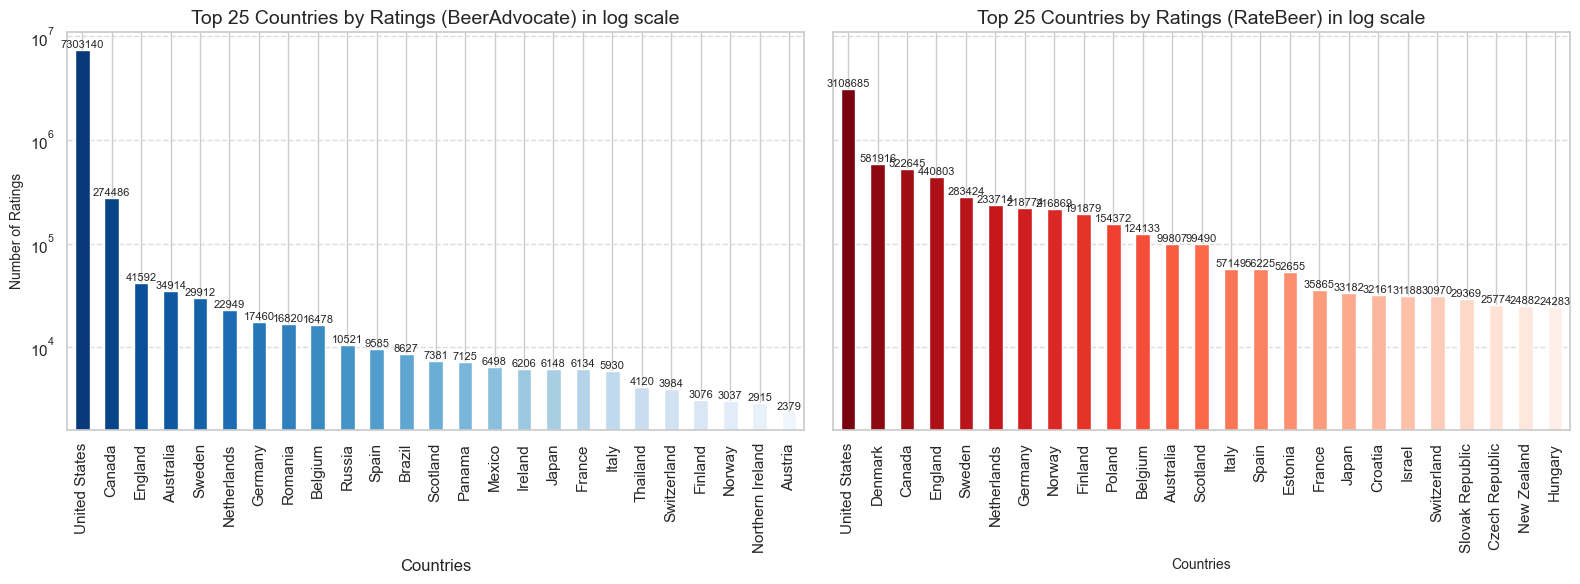

In [97]:
from helpers import ploting_country_representation

# compute number of ratings per country
BA_count_per_country = BA_cleaned.groupby('user_country').size().nlargest(25)
RB_count_per_country = RB_cleaned.groupby('user_country').size().nlargest(25)

ploting_country_representation(BA_count_per_country, RB_count_per_country, 'log')

In [70]:
# top 10 country ratings with precise values
country_comparison = pd.DataFrame({
    'Country (BA)': BA_count_per_country.index,
    '# of Ratings (BeerAdvocate)': BA_count_per_country.values,
    '% of Ratings (BeerAdvocate)': np.round(BA_count_per_country.values / len(BA_cleaned) * 100, 2),
    'Country (RB)': RB_count_per_country.index,
    '# of Ratings (RateBeer)': RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values,
    '% of Ratings (RateBeer)': np.round(RB_count_per_country.reindex(RB_count_per_country.index, fill_value=0).values / len(RB_cleaned) * 100, 2)
})
country_comparison.index = range(1, len(country_comparison) + 1)
country_comparison.head(10)

,Country (BA),# of Ratings (BeerAdvocate),% of Ratings (BeerAdvocate),Country (RB),# of Ratings (RateBeer),% of Ratings (RateBeer)
1,United States,7303140,92.54,United States,3108685,44.93
2,Canada,274486,3.48,Denmark,581916,8.41
3,England,41592,0.53,Canada,522645,7.55
4,Australia,34914,0.44,England,440803,6.37
5,Sweden,29912,0.38,Sweden,283424,4.10
6,Netherlands,22949,0.29,Netherlands,233714,3.38
7,Germany,17460,0.22,Germany,218774,3.16
8,Romania,16820,0.21,Norway,216869,3.13
9,Belgium,16478,0.21,Finland,191879,2.77
10,Russia,10521,0.13,Poland,154372,2.23


> *Here, we see that most of the ratings for both sites comes from USA and Canada first and then from European countries. This means that the project will focus mainly on politics from US/Canada and European countries. To be sure that we are not losing too much data from other continents, we will compute the percentage of ratings coming from US/Canada together and Europe together.*

In [78]:
# list with countries in north america
north_america = [
    "United States", "Canada"
]

# compute total % of ratings from north America for BeerAdvocate
na_BA_percentage = country_comparison[country_comparison['Country (BA)'].isin(north_america)]['% of Ratings (BeerAdvocate)'].sum()
print('Total % of ratings (BeerAdvocate) from North America countries:', round(na_BA_percentage,1), '%')

# compute total % of ratings from north America for RateBeer
na_RB_percentage = country_comparison[country_comparison['Country (RB)'].isin(north_america)]['% of Ratings (RateBeer)'].sum()
print('Total % of ratings (RateBeer) from North America countries:', round(na_RB_percentage,1), '%')


# list with countries in europe
european_countries = [
    "Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium",
    "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark",
    "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland",
    "Ireland", "Italy", "Kazakhstan", "Kosovo", "Latvia", "Liechtenstein", "Lithuania",
    "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia",
    "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia",
    "Slovenia", "Spain", "Sweden", "Switzerland", "Turkey", "Ukraine", "England",
    "Vatican City"
]

# compute total % of ratings from Europe for BeerAdvocate
BA_european_percentage = country_comparison[country_comparison['Country (BA)'].isin(european_countries)]['% of Ratings (BeerAdvocate)'].sum()
print('\nTotal % of ratings (BeerAdvocate) from European countries:', round(BA_european_percentage,1), '%')

# compute total % of ratings from Europe for RateBeer
RB_european_percentage = country_comparison[country_comparison['Country (RB)'].isin(european_countries)]['% of Ratings (RateBeer)'].sum()
print('Total % of ratings (RateBeer) from European countries:', round(RB_european_percentage,1), '%')

# compute and print total loss of ratings coming from other continents for BeerAdvocate
BA_total_loss = 100 - na_BA_percentage - BA_european_percentage
print ("\n\nTotal loss of ratings from other continents for BeerAdvocate :", round(BA_total_loss,1), '%' )

# compute and print total loss of ratings coming from other continents for RateBeer
RB_total_loss = 100 - na_RB_percentage - RB_european_percentage
print ("Total loss of ratings from other continents for RateBeer :", round(RB_total_loss,1), '%' )


Total % of ratings (BeerAdvocate) from North America countries: 96.0 %
Total % of ratings (RateBeer) from North America countries: 52.5 %

Total % of ratings (BeerAdvocate) from European countries: 2.5 %
Total % of ratings (RateBeer) from European countries: 39.9 %


Total loss of ratings from other continents for BeerAdvocate : 1.5 %
Total loss of ratings from other continents for RateBeer : 7.6 %


**Observations for BeerAdvocate :**

    - 96% of ratings from North America, 92.5% from US
    - 2.5% of ratings from Europe
    - 1.5% of ratings from other continents

> *This mean that our first approach will be to see if the political orientation of each US state has an impact on beer ratings (here we will consider Canada as the 51st US state, taking the whole countries political orientation into account). This dataset might not be adequate for Europe since it only represents 2.5% of the dataframe.*


**Observations for RateBeer :**

    - 52.5% of ratings from North America, 44.9% from US
    - 39.9% of ratings from Europe
    - 7.6% of ratings from other continents

> *This means that for this dataframe we will be able to have a proper analysis about US/Canada and Europe since they are both around 45%. However, here, the data that won't be used is about 7.6% which is pretty significant.*

### 2.4 Ratings distribution over users

It is also interesting to explore the quantity of ratings that each user has published. Do we give more importance to regular users than to occasional ones ? Are users who have thousands and thousands of ratings relevant ? Are theses users biasing our result ?

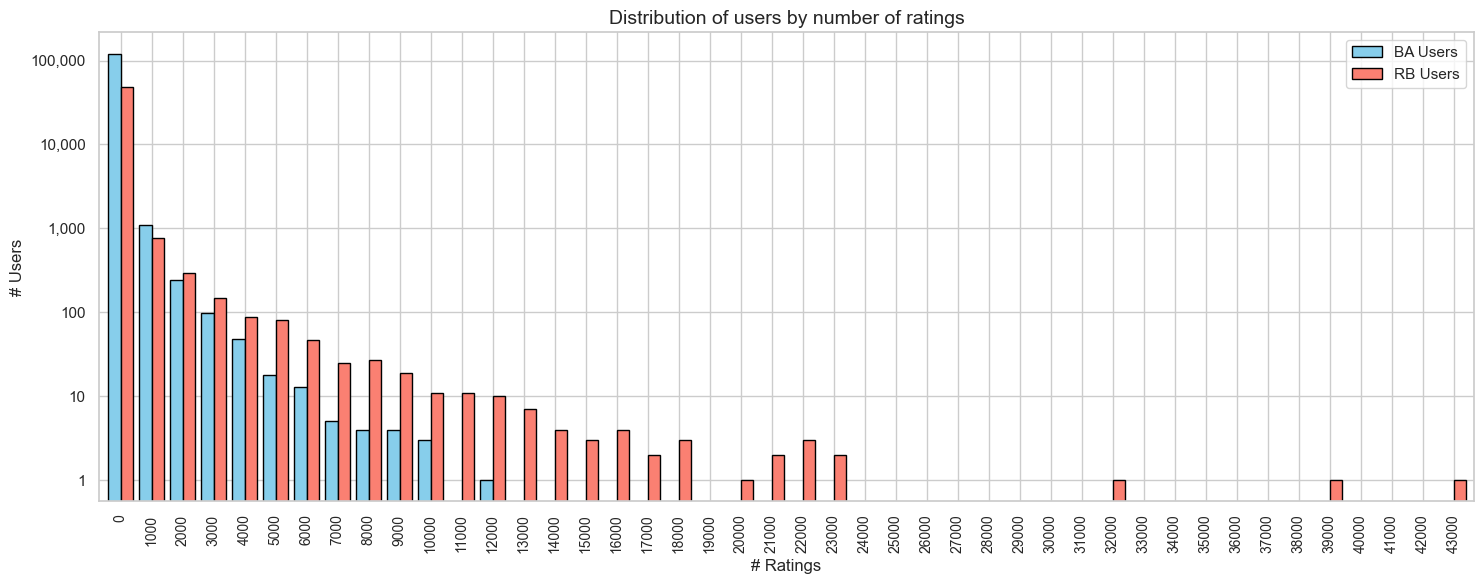

In [84]:
from helpers import ploting_user_ratings_distribution

# Computing the #ratings by users, and grouping them in bins of size 1000
BA_ratings_by_user = BA_cleaned.groupby('user_id').size().reset_index(name='#ratings')
BA_ratings_bins = pd.cut(BA_ratings_by_user['#ratings'], bins=np.arange(0, BA_ratings_by_user['#ratings'].max() + 1000, 1000))
BA_ratings_bins = BA_ratings_bins.value_counts().sort_index()

RB_ratings_by_user = RB_cleaned.groupby('user_id').size().reset_index(name='#ratings')
RB_ratings_bins = pd.cut(RB_ratings_by_user['#ratings'], bins=np.arange(0, RB_ratings_by_user['#ratings'].max() + 1000, 1000))
RB_ratings_bins = RB_ratings_bins.value_counts().sort_index()

# Only show the minial value of the bins in the graph
BA_ratings_bins.index = [f'{int(bin.left)}' for bin in BA_ratings_bins.index]
RB_ratings_bins.index = [f'{int(bin.left)}' for bin in RB_ratings_bins.index]

# Ploting the #ratings by users data
ploting_user_ratings_distribution(BA_ratings_bins, RB_ratings_bins)

# 🔴 TODO GROUP 🔴

### 2.5 Ratings distribution over months

In our analyses, we will compare political properties with beer properties over time. It is important to examine the distribution of ratings across different months to ensure the relevance and validity of our results.

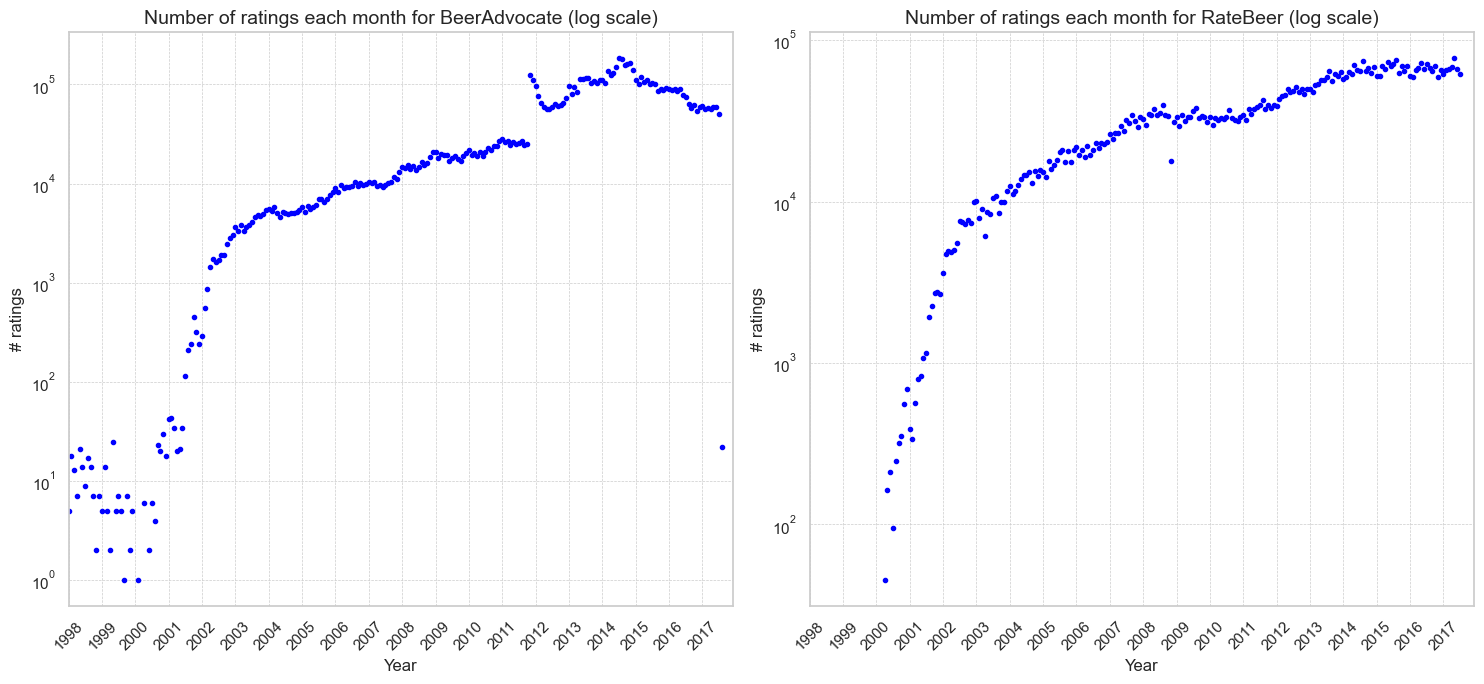

In [102]:
from helpers import ploting_ratings_by_month

# compute the #ratings by month
BA_ratings_by_month = BA_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
BA_ratings_by_month['rating_date'] = pd.to_datetime(BA_ratings_by_month['rating_date'], format='%m-%Y')

RB_ratings_by_month = RB_cleaned.groupby('rating_date').size().reset_index(name='#ratings').sort_index()
RB_ratings_by_month['rating_date'] = pd.to_datetime(RB_ratings_by_month['rating_date'], format='%m-%Y')

# plot the #ratings by months data
ploting_ratings_by_month(BA_ratings_by_month, RB_ratings_by_month, "log")

**For BeerAdvocate :**

> *Before 2002, the number of user ratings each month is very low (under 1000), which may pose problems for conducting a reliable statistical analysis. On the contrary, starting from 2007, there are more than 10,000 ratings per month, providing a solid foundation for more precise analysis. It can also be noted that starting from 2012, the data shows significant volatility, with the number of ratings varying greatly from one month to the next one.*

**For RateBeer :**

> *Before 2003, there is limited data, but after that year, the graph shows a consistent increase of data every month. This suggests that we can have more confidence in our results for the later years.*

## 3. US Politics external datasets processing

As we saw before, the majority of the ratings came from the USA. Thus, the first analysis will be on US politics.

### 3.1 Data loading

In [103]:
# ...
us_pres_df=pd.read_csv('./data/US president/1976-2020-president.csv')
us_pres_df=us_pres_df.loc[us_pres_df.year>1998].reset_index()

us_pres_df['vote_percent']=us_pres_df['candidatevotes']/us_pres_df['totalvotes']*100

us_pres_df.head()

,index,year,state,state_po,state_fips,state_cen,state_ic,office,candidate,party_detailed,writein,candidatevotes,totalvotes,version,notes,party_simplified,vote_percent
0,2042,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"BUSH, GEORGE W.",REPUBLICAN,False,941173,1666272,20210113,NaN,REPUBLICAN,56.483755
1,2043,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"GORE, AL",DEMOCRAT,False,692611,1666272,20210113,NaN,DEMOCRAT,41.566503
2,2044,2000,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,INDEPENDENT,False,25896,1666272,20210113,NaN,OTHER,1.554128
3,2045,2000,ALABAMA,AL,1,63,41,US PRESIDENT,"BROWNE, HARRY",LIBERTARIAN,False,5893,1666272,20210113,NaN,LIBERTARIAN,0.353664
4,2046,2000,ALABAMA,AL,1,63,41,US PRESIDENT,NaN,NaN,True,699,1666272,20210113,NaN,OTHER,0.041950


# 🔴 TODO ALBERTO --> Expliquer le tableau, ce qu'il contient etc... 🔴

### 3.2 Computing Republicans score percentage by state/year

In [105]:
republican_score=us_pres_df.loc[us_pres_df['party_simplified']=='REPUBLICAN'].copy().reset_index()
rep_year_score_df=republican_score.pivot_table(index='state_po',columns='year',values='vote_percent')

rep_year_score_df.head()

year,2000,2004,2008,2012,2016,2020
state_po,,,,,,
AK,58.620955,61.065330,59.424520,54.801577,51.281512,52.833143
AL,56.483755,62.460690,60.316913,60.545822,62.083092,62.031643
AR,51.307198,54.305959,58.715904,60.566936,60.574102,62.395730
AZ,51.021138,54.869434,53.635248,53.654533,48.671616,49.055981
CA,41.651497,44.357696,36.954859,37.120379,31.617107,34.320724


### 3.3 Computing Democrats score percentage by state/year

## 4. Data refinement

In this section, we will discuss our choice of removing some features and some ratings elements due to the quality of the data and the needs we have for it.

TODO Discuter de quelles données on veut supprimer !!

### 3.1 Dropping ratings with the user's location not available (NaN)

In [51]:
# see how much data will be lost by dropping NaN for user_location
BA_unavailable_user_loc = BA_cleaned['user_location'].isna().mean() * 100
RB_unavailable_user_loc  = RB_cleaned['user_location'].isna().mean() * 100

print(f'BeerAdvocate cleaned dataframe (BA_cleaned) has {BA_unavailable_user_loc:.1f}% unavailable data for user location')
print(f'RateBeer cleaned dataframe (RB_cleaned) has {RB_unavailable_user_loc:.1f}% unavailable data for user location')

BeerAdvocate cleaned dataframe (BA_cleaned) has 6.0% unavailable data for user location
RateBeer cleaned dataframe (RB_cleaned) has 2.9% unavailable data for user location


Here, we can see that the amount of data that will get discarded is not negligeable but doesn't affect too much our dataset too. 

In [52]:
BA_refined = BA_cleaned.dropna(subset = ['user_location'])
RB_refined = RB_cleaned.dropna(subset = ['user_location'])

### 3.1 Removing the missing countries

The contry in which the ratings where made is crucial for our analysis, so we decided to remove the ratings where the country field is missing.

In [53]:
# Dropping the element with no country field
BA_refined = BA_cleaned.dropna(subset=['user_country'])
RB_refined = RB_cleaned.dropna(subset=['user_country'])

## 4. External dataset used

## 5. Analysis : Relation Beer vs Political

Partie de Samuel pour creer un dataframe pour les USA et commencer les analyses.

In [54]:
#Create Dataframe of only USA users
RB_usa = RB_cleaned.copy()[RB_cleaned['user_country'].str.contains('United States', case=False, na=False)]
BA_usa = BA_cleaned.copy()[BA_cleaned['user_country'].str.contains('United States', case=False, na=False)]
RB_usa.columns

Index(['rating_date', 'rating_appearance', 'rating_aroma', 'rating_palate',
       'rating_taste', 'rating_overall', 'rating', 'beer_id', 'beer_name',
       'beer_style', 'beer_nbr_ratings', 'overall_score', 'style_score',
       'beer_avg', 'beer_abv', 'beer_avg_computed', 'beer_zscore',
       'beer_nbr_matched_valid_ratings', 'beer_avg_matched_valid_ratings',
       'brewery_id', 'brewery_name', 'breweries_location', 'breweries_country',
       'breweries_state', 'breweries_nbr_beers', 'user_id', 'user_nbr_ratings',
       'user_name', 'user_join_date', 'user_location', 'user_country',
       'user_state'],
      dtype='object')

In [55]:
RB_usa[['beer_id', 'brewery_id', 'rating_date', 'user_id', 'rating_appearance',
       'rating_aroma', 'rating_palate', 'rating_taste', 'rating_overall',
       'rating', 'beer_name', 'brewery_name', 'beer_style', 'beer_nbr_ratings',
       'overall_score', 'style_score', 'beer_avg', 'beer_abv',
       'beer_avg_computed', 'beer_zscore', 'beer_nbr_matched_valid_ratings',
       'beer_avg_matched_valid_ratings', 'breweries_location',
       'breweries_nbr_beers', 'user_nbr_ratings', 'user_name',
       'user_join_date', 'user_location', 'user_country', 'user_state',
       'breweries_country', 'breweries_state']].sample(10)

,beer_id,brewery_id,rating_date,user_id,rating_appearance,rating_aroma,rating_palate,rating_taste,rating_overall,rating,...,breweries_location,breweries_nbr_beers,user_nbr_ratings,user_name,user_join_date,user_location,user_country,user_state,breweries_country,breweries_state
3021551,2319,398,12-2011,136526,3,6,3,6,12,3.0,...,"United States, California",152,1501,zgaier,09-2011,"United States, Florida",United States,Florida,United States,California
2701477,196952,1248,06-2014,139704,4,8,3,8,14,3.7,...,"United States, Wisconsin",93,2172,gregwilsonstl,11-2011,"United States, Missouri",United States,Missouri,United States,Wisconsin
3388829,150353,10514,10-2012,55364,4,7,3,7,14,3.5,...,"United States, Washington",191,1854,robforbes,06-2007,"United States, Washington",United States,Washington,United States,Washington
977767,4584,282,04-2011,92819,2,5,2,6,11,2.6,...,Germany,30,2676,chibuck,07-2009,"United States, Illinois",United States,Illinois,Germany,NaN
6503169,101851,418,09-2013,96469,3,6,3,7,15,3.4,...,Belgium,35,594,RickTStiles,10-2009,"United States, Texas",United States,Texas,Belgium,NaN
5182264,557,93,04-2005,2971,4,7,3,7,13,3.4,...,"United States, Oregon",151,1476,Murphy,01-2002,"United States, Colorado",United States,Colorado,United States,Oregon
2859056,240673,13058,06-2014,162419,4,9,4,8,17,4.2,...,"United States, California",116,1328,tcane7,03-2012,"United States, Pennsylvania",United States,Pennsylvania,United States,California
4012401,17876,3038,01-2006,12355,3,4,2,3,7,1.9,...,"United States, Colorado",13,650,BrockLanders,05-2004,"United States, Florida",United States,Florida,United States,Colorado
2922979,39654,28443,04-2009,65725,4,7,4,8,17,4.0,...,"United States, California",25,1086,angrypirate06,12-2007,"United States, Texas",United States,Texas,United States,California
4513464,350800,18089,07-2016,331396,3,7,4,6,11,3.1,...,"United States, Delaware",43,1851,katrinaez,08-2014,"United States, Pennsylvania",United States,Pennsylvania,United States,Delaware


In [56]:
#Df of the other countries
RB_other = RB_cleaned.copy()[~RB_cleaned['user_country'].str.contains('United States', case=False, na=True)]
BA_other = BA_cleaned.copy()[~BA_cleaned['user_country'].str.contains('United States', case=False, na=True)]

In [57]:
#Top ten beer styles for users of different states for RB

#Democrats States
RB_california = RB_usa.copy()[RB_usa['user_state']=='California']

# Keep the beer if it has at leat 10 ratings
counts = RB_california.groupby('beer_id')['rating'].transform('count')
RB_california = RB_california[counts >= 10]
top10_california = RB_california[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_massachusetts = RB_usa.copy()[RB_usa['user_state']=='Massachusetts']
counts = RB_massachusetts.groupby('beer_id')['rating'].transform('count')
RB_massachusetts = RB_massachusetts[counts >= 10]
top10_massachusetts =RB_massachusetts[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

#Republican States
RB_alabama = RB_usa.copy()[RB_usa['user_state']=='Alabama']
counts = RB_alabama.groupby('beer_id')['rating'].transform('count')
RB_alabama = RB_alabama[counts >= 10]
top10_alabama =RB_alabama[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_indiana = RB_usa.copy()[RB_usa['user_state']=='Indiana']
counts = RB_indiana.groupby('beer_id')['rating'].transform('count')
RB_indiana = RB_indiana[counts >= 10]
top10_indiana =RB_indiana[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_wyoming = RB_usa.copy()[RB_usa['user_state']=='Wyoming']
counts = RB_wyoming.groupby('beer_id')['rating'].transform('count')
RB_wyoming = RB_wyoming[counts >= 5]
top10_wyoming =RB_wyoming[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_style']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)


In [58]:

df_top_5_beer_style = pd.DataFrame({
    'Top 5':np.arange(1,6),
    'California':top10_california.index[:5],
    'Massachusetts': top10_massachusetts.index[:5],
    'Alabama': top10_alabama.index[:5],
    'Indiana': top10_indiana.index[:5],
    'Wyoming': top10_wyoming.index[:5],
})
df_top_5_beer_style

,Top 5,California,Massachusetts,Alabama,Indiana,Wyoming
0,1,Abt/Quadrupel,Abt/Quadrupel,Traditional Ale,Abt/Quadrupel,Foreign Stout
1,2,Lambic Style - Gueuze,Lambic Style - Gueuze,Weizen Bock,Imperial Stout,Brown Ale
2,3,Imperial Stout,Sour/Wild Ale,Abt/Quadrupel,Weizen Bock,Dry Stout
3,4,Sour/Wild Ale,Sour Red/Brown,Imperial Stout,Eisbock,Altbier
4,5,Sour Red/Brown,Imperial Stout,Lambic Style - Gueuze,Sour Red/Brown,Imperial IPA


In [59]:
#Top ten beer for users of different states for RB

#Democrats States
RB_california = RB_usa.copy()[RB_usa['user_state']=='California']

# Keep the beer if it has at leat 10 ratings
counts = RB_california.groupby('beer_id')['rating'].transform('count')
RB_california = RB_california[counts >= 10]
top10_california = RB_california[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_massachusetts = RB_usa.copy()[RB_usa['user_state']=='Massachusetts']
counts = RB_massachusetts.groupby('beer_id')['rating'].transform('count')
RB_massachusetts = RB_massachusetts[counts >= 10]
top10_massachusetts =RB_massachusetts[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

#Republican States
RB_alabama = RB_usa.copy()[RB_usa['user_state']=='Alabama']
counts = RB_alabama.groupby('beer_id')['rating'].transform('count')
RB_alabama = RB_alabama[counts >= 10]
top10_alabama =RB_alabama[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_indiana = RB_usa.copy()[RB_usa['user_state']=='Indiana']
counts = RB_indiana.groupby('beer_id')['rating'].transform('count')
RB_indiana = RB_indiana[counts >= 10]
top10_indiana =RB_indiana[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)[:10]

RB_wyoming = RB_usa.copy()[RB_usa['user_state']=='Wyoming']
counts = RB_wyoming.groupby('beer_id')['rating'].transform('count')
RB_wyoming = RB_wyoming[counts >= 5]
top10_wyoming =RB_wyoming[['beer_name','beer_style','breweries_location','rating']].groupby(['beer_name']).agg({'rating': ['mean','count'],'breweries_location': 'first'}).sort_values(('rating','mean'),ascending=False)


In [60]:
top10_alabama

rating        \
                                                  mean count   
beer_name                                                      
Westvleteren 12 (XII)                         4.538889    18   
Rochefort Trappistes 10                       4.367742    31   
Westvleteren Extra 8                          4.318182    11   
Russian River Pliny the Elder                 4.295238    21   
Girardin Gueuze Black Label                   4.280000    10   
AleSmith Speedway Stout                       4.261111    18   
Great Divide Yeti Imperial Stout - Oak Aged   4.259091    22   
North Coast Old Rasputin (Bourbon Barrel)     4.245455    11   
Hoppin Frog BORIS The Crusher                4.220000    10   
Rogue Imperial Stout                          4.215385    13   

                                                     breweries_location  
                                                                  first  
beer_name                                                                
Westvleteren 12 (XII)                                           Belgium  
Rochefort Trappistes 10                                         Belgium  
Westvleteren Extra 8                                            Belgium  
Russian River Pliny the Elder                 United States, California  
Girardin Gueuze Black Label                                     Belgium  
AleSmith Speedway Stout                       United States, California  
Great Divide Yeti Imperial Stout - Oak Aged     United States, Colorado  
North Coast Old Rasputin (Bourbon Barrel)     United States, California  
Hoppin Frog BORIS The Crusher                      United States, Ohio  
Rogue Imperial Stout                              United States, Oregon

In [61]:
#QUESTIONS :
# 1 : Quels styles de bière les états préfèrent? (selon parti) SAMUEL
# 1.2 : Pourcentage d'alcool ?

# 2 : Quels états préfèrent consommer local(etat-national?,national-international?)DANIEL
# 2.1 mettre en relation avec l'orientation politique


# EN DESSOUS, Cellules de tests, à retirer !!!

In [62]:
from importlib import reload
import helpers
reload(helpers)

<module 'helpers' from '/Users/jackdouniels/Downloads/GitHub/ada-2024-project-casiervert952/helpers.py'>